![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [23]:
data.shape

(10495, 10)

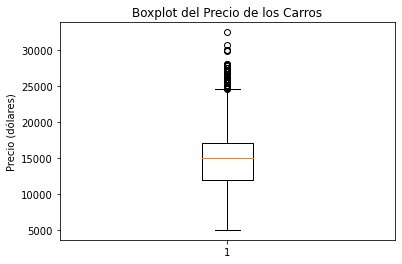

In [4]:
import matplotlib.pyplot as plt

plt.boxplot(y)
plt.title("Boxplot del Precio de los Carros")
plt.ylabel("Precio (dólares)")
plt.show()

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):    
    features = range(X.shape[1])
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)        
            if gain > best_split[2]:
                best_split = [j, split, gain]    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=None):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


def tree_predict(X, tree, proba=False):
    predicted = np.ones(X.shape[0])
    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']  
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
    return predicted

# Entrenamiento y ajuste del arbol
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10)
y_pred = tree_predict(X_test, tree)
y_true = y_test

mse1 = mean_squared_error(y_true, y_pred)
r21 = r2_score(y_true, y_pred)
rmse1 = np.sqrt(mse1)
mae1 = mean_absolute_error(y_true, y_pred)
mape1 =np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Medidas desempeño árbol Manual MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse1, r21,rmse1, mae1,mape1))


Medidas desempeño árbol Manual MSE: 214722281.42, R2: -13.04,RMSE: 14653.41, MAE: 13877.51, MAPE: 95.31


#### Análisis punto 1
De acuerdo con el modelo árbol entrenadado y sus medidas de desempeño se puede concluir:
* El coeficiente de determinación (R2) indica la proporción de la variabilidad en el precio del carro que se puede explicar por el modelo. Un valor de R2 negativo como en este caso (-13.04) sugiere que el modelo no es útil para hacer predicciones precisas.

* El error cuadrático medio (RMSE) correspondiente a la desviación promedio de las predicciones del modelo en comparación con los valores reales. En este caso, el valor del RMSE es alto (14653.41), lo que indica que el modelo tiene un alto grado de error y no es muy preciso.

* El error absoluto medio (MAE) es similar al RMSE, pero en lugar de elevar al cuadrado las diferencias entre las predicciones y los valores reales, se toma el valor absoluto. Un valor alto del MAE (como en este caso, 13877.51) sugiere que el modelo no es muy preciso.

* El error porcentual absoluto medio (MAPE) es una medida de la precisión del modelo en términos de porcentaje. El valor alto del MAPE (95.31) sugiere que el modelo tiene una precisión muy baja y no es confiable para hacer predicciones precisas.

*Es necesarion analizar las variables importantes que el modelo utilizó para hacer las predicciones. Esto puede ayudar a identificar qué variables son más importantes para la definición del Preci y proporcionar información valiosa para futuros análisis y modelos.

En resumen, los resultados del modelo de árbol entrenado con todas las variables predictoras indican que el modelo no es muy preciso y no es útil para hacer predicciones precisas. Se deben analizar otras variables y modelos para determinar qué factores están afectando el rendimiento del modelo actual.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2

# Se crea un arreglo de 1 a 20
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, 21)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [ 6 12 13  9 10 12  6 16  1 17  2 13  8 14  7 19  6 19 12 11]


In [8]:
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [9]:
# Visualización muestra boostrap #1 para entremiento
X_train.iloc[samples[0], :]

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
151599,2016,40999,0,0,0,0,0,1,0
171999,2014,52527,0,0,0,0,0,1,0
304172,2009,123202,0,1,0,0,0,0,0
74828,2015,38807,0,0,0,0,0,1,0
192974,2005,51260,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
134843,2014,22221,0,0,0,0,1,0,0
325075,2013,86593,0,0,0,0,0,1,0
61213,2014,28044,0,0,0,0,0,1,0
181222,2016,49368,0,0,0,0,0,0,1


In [10]:
# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    XX_train = X_train.iloc[sample, :]
    yy_train = y_train.iloc[sample]
    treereg.fit(XX_train, yy_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [11]:
# Desempeño de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  2141.613353645869
Árbol  1 tiene un error:  2136.3519863123465
Árbol  2 tiene un error:  2122.718759132052
Árbol  3 tiene un error:  2087.278992468617
Árbol  4 tiene un error:  2168.518742842026
Árbol  5 tiene un error:  2113.8811455834793
Árbol  6 tiene un error:  2127.933470769012
Árbol  7 tiene un error:  2184.414847251443
Árbol  8 tiene un error:  2138.1071697514985
Árbol  9 tiene un error:  2132.097520859104


In [12]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: float64

In [13]:
Ypred2=y_pred.mean(axis=1)
Ypred2

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: float64

In [14]:
# Error al promediar las predicciones de todos los árboles

mse_bm = mean_squared_error(y_true, Ypred2)
r2_bm = r2_score(y_true, Ypred2)
rmse_bm = np.sqrt(mse_bm)
mae_bm = mean_absolute_error(y_true, Ypred2)
mape_bm =np.mean(np.abs((y_true - Ypred2) / y_true)) * 100

print("Medidas desempeño Bagging Manual MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse_bm, r2_bm,rmse_bm, mae_bm,mape_bm))

Medidas desempeño Bagging Manual MSE: 3227180.82, R2: 0.79,RMSE: 1796.44, MAE: 1340.02, MAPE: 9.76


#### Análisis punto 2

De acuerdo con el modelo Bagging Manual y sus medidas de desempeño se puede concluir:
    
* En este caso, el valor de R2 es alto (0.79), lo que sugiere que el modelo es bastante bueno para hacer predicciones.

* En este caso, el valor del RMSE es relativamente bajo (1796.44), lo que indica que el modelo tiene un bajo grado de error y es bastante preciso.

* Un valor bajo del MAE (como en este caso, 1340.02) sugiere que el modelo es bastante preciso.

* El valor bajo del MAPE (9.76) sugiere que el modelo tiene una precisión bastante buena y es confiable para hacer predicciones precisas.


Al usar Bagging, se pueden reducir el sesgo y la varianza del modelo, lo que puede conducir a mejores resultados; con los resultados del modelo; se puede indicar que éste es bastante preciso y confiable para hacer predicciones precisas. 

Además, el uso de la técnica de Bagging puede haber ayudado a mejorar la precisión del modelo frente al anterior. Sin embargo, se deben realizar análisis adicionales para determinar si se pueden mejorar aún más los resultados del modelo y para identificar qué factores están afectando el rendimiento del modelo actual.


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [21]:
# Celda 3

# Calcular el valor de max_features
n_features = X_train.shape[1]
max_features = int(math.log(n_features))

bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, 
                          bootstrap=True, oob_score=True, random_state=1, max_features = max_features)

# Entrenamiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)

# Cálculo del error del modelo
mse_bg = mean_squared_error(y_true, y_pred)
r2_bg = r2_score(y_true, y_pred)
rmse_bg = np.sqrt(mse_bg)
mae_bg = mean_absolute_error(y_true, y_pred)
mape_bg =np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Medidas desempeño Bagging Librería MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse_bg, r2_bg,rmse_bg, mae_bg,mape_bg))


Medidas desempeño Bagging Librería MSE: 7134309.37, R2: 0.53,RMSE: 2671.01, MAE: 2074.98, MAPE: 17.33


#### Análisis punto 3

De acuerdo con el modelo Bagging con librería y sus medidas de desempeño se puede concluir:

* El valor de R2 es moderado (0.53), lo que sugiere que el modelo es útil para hacer predicciones, pero que no explica completamente la variabilidad de los datos.

* El RMSE es moderado (2671.01), lo que indica que el modelo tiene un grado moderado de error y puede haber algunas inexactitudes en las predicciones.

* El valor moderado del MAE (2074.98) sugiere que el modelo puede estar cometiendo algunos errores en sus predicciones, pero no a un nivel muy alto.

* El MAPE (17.33) sugiere que el modelo puede estar cometiendo algunos errores en sus predicciones, pero nuevamente, no a un nivel muy alto.

* Al usar Bagging, se pueden reducir el sesgo y la varianza del modelo, lo que puede conducir a mejores resultados. En este caso, al utilizar la librería para el modelo Bagging, se puede esperar que el modelo sea más preciso y confiable que un modelo creado manualmente; aunque para este caso no se ha cumplido la hipótesis lo cual puede ser a los parámetros con los que se ha calibrado el ensamble con todas las variables predictoras (10) y con el  "max_features" al número  máximo.

En resumen, los resultados del modelo Bagging con la librería sugieren que el modelo es útil para hacer predicciones, pero puede haber algunas inexactitudes en las predicciones. El uso de la técnica de Bagging y la librería puede haber ayudado a mejorar la precisión del modelo en comparación con un modelo creado manualmente. Se deben realizar análisis adicionales para identificar qué factores están afectando el rendimiento del modelo actual y para determinar si se pueden mejorar aún más los resultados del modelo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [16]:
# Celda 4

# Definición de modelo Random Forest
clf = RandomForestRegressor()

# Entrenar el modelo con los datos de entrenamiento
clf.fit(X_train, y_train)

# Realizar predicciones con el modelo calibrado
y_pred = clf.predict(X_test)  # X_test son los datos de prueba

# Evaluar el desempeño del modelo
mse_rf = mean_squared_error(y_true, y_pred)
r2_rf = r2_score(y_true, y_pred)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_true, y_pred)
mape_rf =np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Medidas desempeño Random Forest MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse_rf, r2_rf,rmse_rf, mae_rf,mape_rf))

Medidas desempeño Random Forest MSE: 3088732.73, R2: 0.80,RMSE: 1757.48, MAE: 1309.21, MAPE: 9.51


#### Análisis punto 4

De acuerdo con el modelo Random Forest con librería y sus medidas de desempeño se puede concluir:

En este caso, el valor de MSE es de 3088732.73, lo que indica que el modelo tiene un buen ajuste a los datos.

* En este caso, el valor de R2 es de 0.80, lo que indica que el modelo explica el 80% de la variabilidad en los datos.

* El valor de RMSE indica que las predicciones del modelo tienen un error medio de aproximadamente 1757.48 unidades del precio del automóvil.

* El valor de MAE sugiere que las predicciones del modelo tienen un error medio absoluto de aproximadamente 1309.21 unidades del precio predicho.

* El valor de MAPE indica que las predicciones del modelo tienen un error medio porcentual absoluto de aproximadamente 9.51% en relación con los valores reales de la variable objetivo.

En general, se puede decir que el modelo de Random Forest tiene un buen desempeño, ya que tiene un MSE relativamente bajo, un R2 alto y valores de RMSE, MAE y MAPE aceptables para la definición del precio del automóvil.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de RandomForest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Mejor max_depth:  10
Mejor max_features:  sqrt
Mejor n_estimators:  200


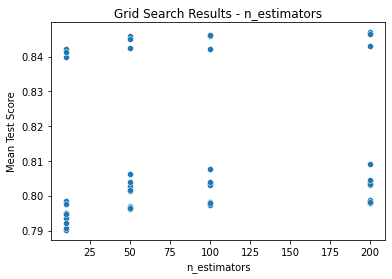

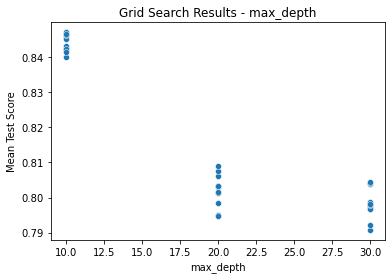

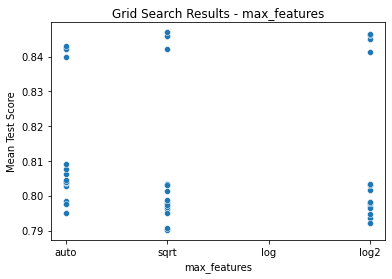

Medidas desempeño Random Forest Calibrado MSE: 2443390.81, R2: 0.84,RMSE: 1563.13, MAE: 1147.23, MAPE: 8.38


In [17]:
# Crear el modelo de Random Forest
rf_model = RandomForestRegressor()

# Definir los valores para los parámetros a calibrar
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Valores a probar para max_depth
    'max_features': ['auto', 'sqrt', 'log', 'log2'],  # Valores a probar para max_features
    'n_estimators': [10, 50, 100, 200]  # Valores a probar para n_estimators
}

# Realizar la búsqueda exhaustiva de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)  # X_train, y_train son los datos de entrenamiento

# Imprimir los mejores hiperparámetros encontrados
print("Mejor max_depth: ", grid_search.best_params_['max_depth'])
print("Mejor max_features: ", grid_search.best_params_['max_features'])
print("Mejor n_estimators: ", grid_search.best_params_['n_estimators'])

# Obtener los resultados de la búsqueda de hiperparámetros
results = grid_search.cv_results_

# Crear un gráfico de puntos para los resultados de n_estimators
sns.scatterplot(x='param_n_estimators', y='mean_test_score', data=results)
plt.xlabel('n_estimators')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results - n_estimators')
plt.show()

# Crear un gráfico de puntos para los resultados de max_depth
sns.scatterplot(x='param_max_depth', y='mean_test_score', data=results)
plt.xlabel('max_depth')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results - max_depth')
plt.show()

# Crear un gráfico de puntos para los resultados de max_features
sns.scatterplot(x='param_max_features', y='mean_test_score', data=results)
plt.xlabel('max_features')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results - max_features')
plt.show()

# Obtener los mejores valores de los hiperparámetros
best_max_depth = grid_search.best_params_['max_depth']
best_max_features = grid_search.best_params_['max_features']
best_n_estimators = grid_search.best_params_['n_estimators']

# Crear un nuevo modelo de Random Forest con los mejores hiperparámetros
best_rf_model = RandomForestRegressor(max_depth=best_max_depth, max_features=best_max_features,
                                      n_estimators=best_n_estimators)

# Entrenar el modelo con los datos de entrenamiento
best_rf_model.fit(X_train, y_train)

# Realizar predicciones con el modelo calibrado
y_pred = best_rf_model.predict(X_test)  # X_test son los datos de prueba

# Evaluar el desempeño del modelo
mse_best_rf = mean_squared_error(y_test, y_pred)  # y_test son las etiquetas verdaderas de los datos de prueba
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_true, y_pred)
mae_best_rf = mean_absolute_error(y_true, y_pred)
mape_best_rf =np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Medidas desempeño Random Forest Calibrado MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse_best_rf, r2_best_rf,rmse_best_rf, mae_best_rf,mape_best_rf))

#### Análisis punto 5

El modelo calibrado obtuvo mejores metricas frente al no calibrado en el punto anterior:
- MSE: 2443390.81 vs 3088732.73 (punto 4)
- R2: 0.84 vs 0.80 (punto 4)
- RMSE: 1563.13 vs 1757.48 (punto 4)
- MAE: 1147.23 vs 1309.21 (punto 4)
- MAPE: 8.38 vs 9.51 (punto 4)

Centrándonos en el MAPE, el promedio de los errores porcentuales es de 8.38 frente al 9.51 que obtuvimos en el modelo sin calibración, es decir 0.93% menos, logrando una mejor capacidad para hacer predicciones más precisas del Precio del automóvil.

En el desarrollo del modelo de Random Forest de este punto se calibraron los parametros max_depth, max_features y n_estimators de acuerdo a los siguientes parametros:
1. max_depth: None, **10**, 20, 30
2. max_features: auto, **sqrt**, log', log2
3. n_estimators: 10, 50, 100, **200**

* El primero de estos, "max_depth", corresponde al número maximo de arboles que puede tener un arbol en el modelo. Entre más alto sea el valor de este parametro, mayor es la posibilidad de que el modelo se sobreajuste a los datos de entrenamiento. En el ejercicio podemos observar mejor parametro para "max_depth" fue de 10 en este caso.

* El segundo parametro calibrado, "max_features", corresponde al número máximo de características que se utilizan para cada árbol del modelo. Al igual que el anterior parametro, un mayor número de caractericticas como en cada arbol, conllevará a sobreajustes, capturando el desempeño de los datos de entrenamiento. En el ejercicio podemos observar que el mejor parametro para "max_features" dentro de los evaluados corresponde al sqrt, siendo la raíz cuadrada del número total de características.

* Por último, "n_estimators" hace referencia al número de arboles de decisión que se utilizarán en la construcción del modelo Random Forest. Entre más alto sea este parámetro, mayor puede ser la precisión del modelo, pero mayor será el tiempo de entrenamiento y la complejidad del modelo, conllevando a sobreajustes frente a los datos de entrenamiento. En el ejercicio, el mejor parametro para "n_estimators" dentro de los evaluados es de 200.

Es importante considerar los tres parámetros, max_depth, max_features y n_estimators, ya que tienen un impacto significativo en el modelo de Random Forest. Un ajuste apropiado de estos parámetros es crucial para obtener un modelo preciso y estable, que tenga una alta capacidad de generalización. 

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [18]:
# Celda 6
clf = xgb.XGBRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluar el desempeño del modelo
mse_xgb = mean_squared_error(y_test, y_pred)  # y_test son las etiquetas verdaderas de los datos de prueba
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_true, y_pred)
mae_xgb = mean_absolute_error(y_true, y_pred)
mape_xgb =np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Medidas desempeño XGBoost MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse_xgb, r2_xgb,rmse_xgb, mae_xgb,mape_xgb))

Medidas desempeño XGBoost MSE: 2629001.84, R2: 0.83,RMSE: 1621.42, MAE: 1186.63, MAPE: 8.65


#### Análisis punto 6

Al desarrollar el modelo XGBoost, sin calibrar sus parametros obtuvimos los siguientes indicadores de desempeño.
- MSE: 2629001.84
- R2: 0.83
- RMSE: 1621.42
- MAE: 1186.63
- MAPE: 8.65

Con lo anterior, el modelo sin calibrar presenta un MAPE de 8.65, lo cual se puede traducir como que en promedio las predicciones del modelo tienen un error absoluto de 8.65%. con un error cuadratico medio (MSE) de 2629001 y un buen desempeño en general para la predicción dle precio.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Mejor learning_rate:  0.1
Mejor gamma:  0
Mejor colsample_bytree:  0.8


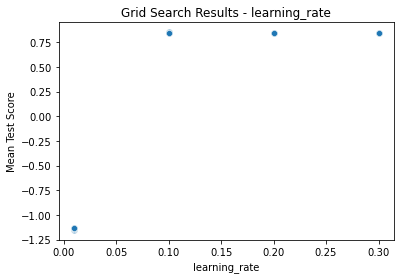

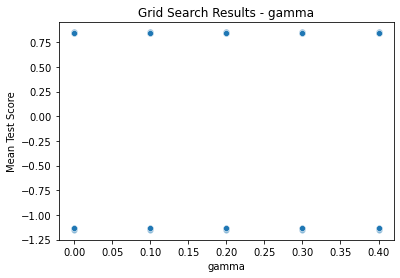

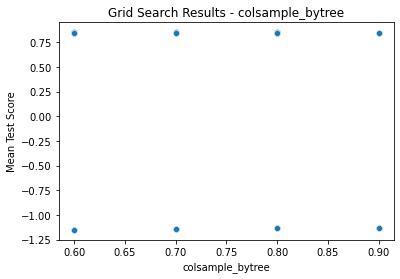

Medidas desempeño XGBoost Calibrado MSE: 2402133.86, R2: 0.84,RMSE: 1549.88, MAE: 1136.64, MAPE: 8.26


In [19]:
# Celda 7

# Crear un regresor de XGBoost
xgb_model = xgb.XGBRegressor()

# Definir los parámetros y los rangos de búsqueda para la calibración
params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # Valores a probar para learning_rate
    'gamma': [0, 0.1, 0.2, 0.3, 0.4], # Valores a probar para gamma
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9] # Valores a probar para colsample_bytree
}

# Realizar búsqueda de hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(xgb_model, params, cv=5)
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejor learning_rate: ", grid_search.best_params_['learning_rate'])
print("Mejor gamma: ", grid_search.best_params_['gamma'])
print("Mejor colsample_bytree: ", grid_search.best_params_['colsample_bytree'])

# Obtener los resultados de la búsqueda de hiperparámetros
results = grid_search.cv_results_

# Crear un gráfico de puntos para los resultados de n_estimators
sns.scatterplot(x='param_learning_rate', y='mean_test_score', data=results)
plt.xlabel('learning_rate')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results - learning_rate')
plt.show()

# Crear un gráfico de puntos para los resultados de max_depth
sns.scatterplot(x='param_gamma', y='mean_test_score', data=results)
plt.xlabel('gamma')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results - gamma')
plt.show()

# Crear un gráfico de puntos para los resultados de max_features
sns.scatterplot(x='param_colsample_bytree', y='mean_test_score', data=results)
plt.xlabel('colsample_bytree')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results - colsample_bytree')
plt.show()

# Obtener los mejores valores de los hiperparámetros
best_learning_rate = grid_search.best_params_['learning_rate']
best_gamma = grid_search.best_params_['gamma']
best_colsample_bytree = grid_search.best_params_['colsample_bytree']

# Crear un nuevo modelo de XGB con los mejores hiperparámetros
best_xgb_model = xgb.XGBRegressor(learning_rate = best_learning_rate, gamma = best_gamma, colsample_bytree = best_colsample_bytree)

# Entrenar el modelo con los datos de entrenamiento
best_xgb_model.fit(X_train, y_train)

# Realizar predicciones con el modelo calibrado
y_pred = best_xgb_model.predict(X_test)  # X_test son los datos de prueba

# Evaluar el desempeño del modelo
mse_best_xgb = mean_squared_error(y_test, y_pred)  # y_test son las etiquetas verdaderas de los datos de prueba
rmse_best_xgb = np.sqrt(mse_best_xgb)
r2_best_xgb = r2_score(y_true, y_pred)
mae_best_xgb = mean_absolute_error(y_true, y_pred)
mape_best_xgb =np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Medidas desempeño XGBoost Calibrado MSE: {:.2f}, R2: {:.2f},RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(mse_best_xgb, r2_best_xgb,rmse_best_xgb, mae_best_xgb,mape_best_xgb))

#### Análisis punto 7

Al desarrollar el modelo XGBoost calibrando sus parametros obtuvimos mejoría en tres indicadores de desempeño frente a los vistos en el punto anterior.
- MSE: 2402133.86 vs 2629001.84 (punto 6)
- R2: 0.84 vs 0.83 (punto6)
- RMSE: 1549.88 vs 1621.42 (punto 6)
- MAE: 1136.64, vs 1186.63 (punto 6)
- MAPE: 8.26 vs 8.65 (punto 6)

Centrandonos en el MAPE, el promedio de los errores porcentuales del modelo XGBoost calibrado es de 8.26 frente al 8.65 que obtuvimos en el modelo sin calibración, es decir 0.39% menos.

En la calibración del modelo se utilizaron los siguientes valores sobre los parametros indicados:

- learning_rate: 0.01, **0.1**, 0.2, 0.3
- gamma: **0**, 0.1, 0.2, 0.3, 0.4
- colsample_bytree: 0.6, 0.7, **0.8**, 0.9

* El primer elemento a calibrar, "learning_rate", corresponde a la tasa de aprendizaje con la cual el modelo actualizará los pesos de los arboles en para iteración en el proceso de entrenamiento. 

* La definición de esta tasa impactara el tiempo con el que el modelo encontrará una solución optima, con lo cual un alto valor en este parametro hará que el modelo se desarrolle más rapidamente, pero se sobreajuste. En contra parte, un menor valor en este parametro mejorará la capacidad del modelo para generalizar. En linea con lo anterior, en nuestro caso, tras evaluar 4 valores, el mejor parametro fue 0.1.

* Frente al parametro gamma, corresponde al valor con el cual el modelo aplicará la restricción de ganancia mínima de partición durante el entrenamiento. En este caso si el valor es bajo el modelo divide el conjunto de datos en demasiados nodos, lo que dará lugar a un modelo más complejo que podría estar sobreajustado, un valor alto conllevara a un modelo más simple con menor precisión, y en caso de ser 0 el modelo no aplicará restricción de ganancia y así podrá hacer un mayor número de particiones.

* Por último, el parametro colsample_bytree ajusta la proporción de caracteristicas que se utilizaran en cada arbol en el proceso de entrenamiento. En linea con esto, este parametro debe estar entre 0 y 1, consideran que el valor de 1 hará que todas las caracteristicas de la base de datos se utilicen en el proceso de entrenamiento, lo cual conllevara a sobreajustes sobre estos datos. En nuestro caso el mejor valor evaluado fue de 0.8.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [20]:
# Celda 8
# Crear una lista con los nombres de las filas
filas = ['MSE', 'RMSE', 'R2', 'MAE','MAPE']

# Crear un diccionario con los datos de las columnas
datos = {'Árbol Manual': [round(mse1,4), round(r21,4),round(rmse1,4), round(mae1,4),round(mape1,4)],
         'Bagging Manual': [round(mse_bm,4), round(r2_bm,4),round(rmse_bm,4), round(mae_bm,4),round(mape_bm,4)],
         'Bagging Librería': [mse_bm, r2_bm,rmse_bm, mae_bm,mape_bm],
         'Random Forest': [mse_rf, r2_rf,rmse_rf, mae_rf,mape_rf],
         'Random Calibrado': [mse_best_rf, r2_best_rf,rmse_best_rf, mae_best_rf,mape_best_rf],
         'XGBoost': [mse_xgb, r2_xgb,rmse_xgb, mae_xgb,mape_xgb],
         'XGBoost Calibrado': [mse_best_xgb, r2_best_xgb,rmse_best_xgb, mae_best_xgb,mape_best_xgb]
        }

# Crear el DataFrame con los nombres de filas y columnas
tabla = pd.DataFrame(datos, index=filas)
tabla

,Árbol Manual,Bagging Manual,Bagging Librería,Random Forest,Random Calibrado,XGBoost,XGBoost Calibrado
MSE,2.147223e+08,3.227181e+06,3.227181e+06,3.088733e+06,2.443391e+06,2.629002e+06,2.402134e+06
RMSE,-1.303770e+01,7.890000e-01,7.890200e-01,7.980712e-01,8.402610e-01,8.281265e-01,8.429582e-01
R2,1.465341e+04,1.796436e+03,1.796436e+03,1.757479e+03,1.563135e+03,1.621420e+03,1.549882e+03
MAE,1.387751e+04,1.340016e+03,1.340016e+03,1.309211e+03,1.147234e+03,1.186634e+03,1.136644e+03
MAPE,9.530660e+01,9.762300e+00,9.762286e+00,9.506345e+00,8.381690e+00,8.648872e+00,8.258863e+00


## Análisis Punto 8

Se listan los hallazgos encontrados de acuerdo con las medidas de desempeño:

* Árbol Manual: Este modelo tiene un MSE alto y un R2 bajo, lo que indica un rendimiento pobre en términos de la capacidad de explicar la variabilidad en los datos y de la precisión de las predicciones. El MAE y el MAPE son muy altos, lo que indica una gran cantidad de errores en las predicciones.

* Bagging Manual: Este modelo tiene un MSE relativamente bajo y un R2 más alto que el Árbol Manual, lo que sugiere una mejora en la capacidad de explicar la variabilidad en los datos y de la precisión de las predicciones. El MAE y el MAPE también son más bajos que el Árbol Manual, lo que indica una mejora en la precisión de las predicciones.

* Bagging Librería: Este modelo tiene medidas de desempeño similares al Bagging Manual, lo que indica que la implementación de la librería no ha mejorado significativamente el rendimiento del modelo.

* Random Forest: Este modelo tiene un MSE bajo y un R2 alto, lo que indica un buen rendimiento en términos de la capacidad de explicar la variabilidad en los datos y de la precisión de las predicciones. El RMSE, MAE y MAPE también son bajos, lo que indica una alta precisión en las predicciones.

* Random Calibrado: Este modelo tiene un MSE más bajo que el Random Forest, lo que indica una mejora en la precisión de las predicciones. El R2, RMSE, MAE y MAPE son similares al Random Forest, lo que sugiere un rendimiento similar en general.

* XGBoost: Este modelo tiene un MSE y un R2 más bajos que el Random Forest, lo que indica un rendimiento ligeramente inferior en términos de la capacidad de explicar la variabilidad en los datos y de la precisión de las predicciones. Sin embargo, el RMSE, MAE y MAPE son más bajos que el Random Forest, lo que indica una mayor precisión en las predicciones.

* XGBoost Calibrado: Este modelo tiene medidas de desempeño similares al XGBoost, lo que indica que la calibración no ha mejorado significativamente el rendimiento del modelo.

El Random Forest y el XGBoost son los modelos que tienen un mejor desempeño en términos de precisión de las predicciones, mientras que el Árbol Manual es el que tiene el peor desempeño